In [23]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline        import Pipeline
from sklearn.impute          import SimpleImputer
from sklearn.metrics         import classification_report, roc_auc_score, ConfusionMatrixDisplay, average_precision_score

from sklearn import metrics
from sklearn.metrics import mean_squared_error, precision_score, confusion_matrix, accuracy_score

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import eli5
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv("data/dataset_merged.csv")
df.head()

,kepid,asymmetry_index,v_u_kurtosis,ingress_slope,egress_slope,loc_rowid,kepoi_name,kepler_name,koi_disposition,koi_fpflag_nt,...,koi_depth,koi_depth_err1,koi_depth_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_srad,koi_srad_err1,koi_srad_err2
0,10797460,0.202138,2.686735,-0.005564,0.000715,1,K00752.01,Kepler-227 b,CONFIRMED,0,...,615.8,19.5,-19.5,35.8,5455.0,81.0,-81.0,0.927,0.105,-0.061
1,10797460,0.202138,2.686735,-0.005564,0.000715,1,K00752.01,Kepler-227 b,CONFIRMED,0,...,615.8,19.5,-19.5,35.8,5455.0,81.0,-81.0,0.927,0.105,-0.061
2,10797460,0.207507,2.385817,-0.000058,0.003326,1,K00752.01,Kepler-227 b,CONFIRMED,0,...,615.8,19.5,-19.5,35.8,5455.0,81.0,-81.0,0.927,0.105,-0.061
3,10797460,0.207507,2.385817,-0.000058,0.003326,1,K00752.01,Kepler-227 b,CONFIRMED,0,...,615.8,19.5,-19.5,35.8,5455.0,81.0,-81.0,0.927,0.105,-0.061
4,10797460,0.207507,2.385817,-0.000058,0.003326,1,K00752.01,Kepler-227 b,CONFIRMED,0,...,615.8,19.5,-19.5,35.8,5455.0,81.0,-81.0,0.927,0.105,-0.061


In [26]:
drop_list = [
    # identificadores
    "kepler_name", "kepid", "kepoi_name", "loc_rowid",

    # flags internos
    "koi_fpflag_nt", "koi_fpflag_ss", "koi_fpflag_co",

    # columnas de errores numéricos
    "koi_period_err1", "koi_period_err2",
    "koi_time0bk_err1", "koi_time0bk_err2", "koi_time0_err1", "koi_time0_err2",
    "koi_impact_err1", "koi_impact_err2",
    "koi_duration_err1", "koi_duration_err2", "koi_ingress",
    "koi_ingress_err1", "koi_ingress_err2", "ingress_slope", "koi_time0bk",
    "koi_depth_err1", "koi_depth_err2",
    "koi_steff_err1", "koi_steff_err2",
    "koi_srad_err1", "koi_srad_err2", "koi_impact"
]

In [27]:
# aplica el drop
df_clean = df.drop(columns=drop_list, errors="ignore")

# eliminar filas sin label
df_clean = df_clean.dropna(subset=["koi_disposition"])

# convertir disposición a binaria
df_clean = df_clean[df_clean["koi_disposition"].isin(["CONFIRMED", "FALSE POSITIVE"])]
df_clean["koi_disposition"] = df_clean["koi_disposition"].map({"FALSE POSITIVE": 0, "CONFIRMED": 1})

cols_key = ["koi_period", "koi_duration", "koi_depth", "koi_snr"]
cols_key = [c for c in cols_key if c in df_clean.columns]

if cols_key:
    df_clean = df_clean.dropna(subset=cols_key)
    print(f"Filtrado por columnas clave: {cols_key}")
else:
    print("Ninguna de las columnas clave se encontró en el DataFrame.")

print("shape final:", df_clean.shape)


Filtrado por columnas clave: ['koi_period', 'koi_duration', 'koi_depth']
shape final: (1944, 11)


In [28]:
df_clean

,asymmetry_index,v_u_kurtosis,egress_slope,koi_disposition,koi_period,koi_time0,koi_duration,koi_depth,koi_model_snr,koi_steff,koi_srad
0,0.202138,2.686735,0.000715,1,9.488036,2455003.539,2.9575,615.8,35.8,5455.0,0.927
1,0.202138,2.686735,0.000715,1,9.488036,2455003.539,2.9575,615.8,35.8,5455.0,0.927
2,0.207507,2.385817,0.003326,1,9.488036,2455003.539,2.9575,615.8,35.8,5455.0,0.927
3,0.207507,2.385817,0.003326,1,9.488036,2455003.539,2.9575,615.8,35.8,5455.0,0.927
4,0.207507,2.385817,0.003326,1,9.488036,2455003.539,2.9575,615.8,35.8,5455.0,0.927
...,...,...,...,...,...,...,...,...,...,...,...
1939,0.265015,2.652737,0.003057,1,42.472908,2454979.287,7.2530,334.0,22.8,5616.0,1.111
1940,NaN,3.059239,0.002773,1,15.170269,2454965.666,4.3311,224.8,45.4,6297.0,1.369
1941,NaN,3.059239,0.002773,1,15.170269,2454965.666,4.3311,224.8,45.4,6297.0,1.369
1942,NaN,1.630420,-0.002112,1,17.815969,2454967.483,3.6765,776.8,22.5,5964.0,0.933


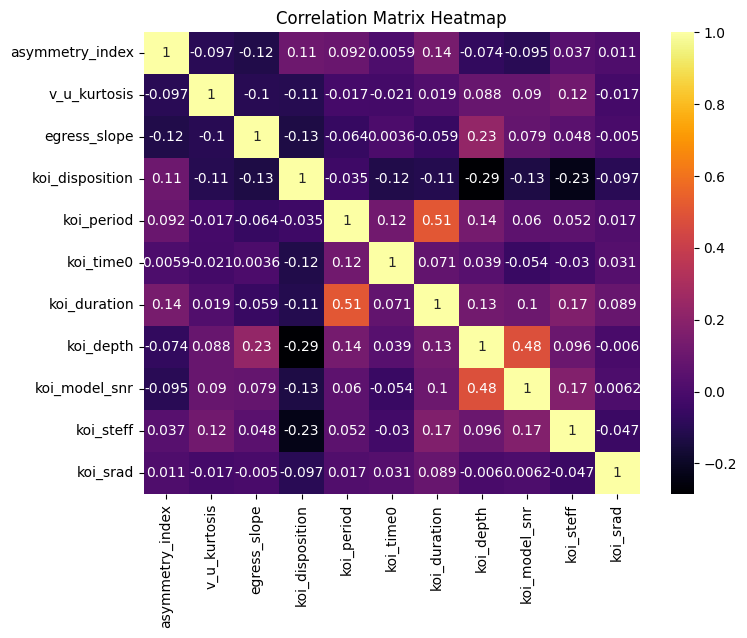

In [29]:
# Calculate the correlation matrix
corr = df_clean.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='inferno')
plt.title('Correlation Matrix Heatmap')
plt.show()


In [30]:
X = df_clean.drop(columns=["koi_disposition"])
y = df_clean["koi_disposition"]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1337, stratify=y
)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight='balanced',
        random_state=42
    ))
])

In [32]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = cross_val_score(
    pipe, X, y, cv=cv, scoring=make_scorer(f1_score)
)
roc_scores = cross_val_score(
    pipe, X, y, cv=cv, scoring="roc_auc"
)

print("CV F1 mean ± std:", f1_scores.mean(), "±", f1_scores.std())
print("CV ROC-AUC mean ± std:", roc_scores.mean(), "±", roc_scores.std())


CV F1 mean ± std: 0.9663499473512038 ± 0.006222756623421895
CV ROC-AUC mean ± std: 0.9902108260351138 ± 0.0021576610440670278


In [33]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       121
           1       0.96      0.97      0.96       268

    accuracy                           0.95       389
   macro avg       0.94      0.94      0.94       389
weighted avg       0.95      0.95      0.95       389

ROC-AUC: 0.9865394103860861
PR-AUC: 0.9934707631703575

Evaluation Metrics:
Accuracy: 0.9485861182519281
Recall: 0.9701492537313433
F1 Score: 0.9629629629629629
Precision: 0.9558823529411765


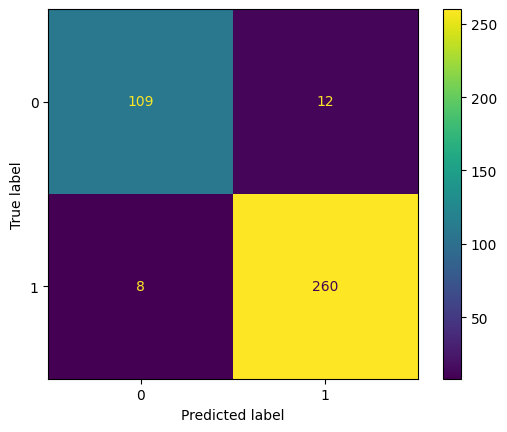

In [34]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))

print()
print('Evaluation Metrics:')
print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
print('Recall: ' + str(metrics.recall_score(y_test, y_pred)))
print('F1 Score: ' + str(metrics.f1_score(y_test, y_pred)))
print('Precision: ' + str(metrics.precision_score(y_test, y_pred)))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

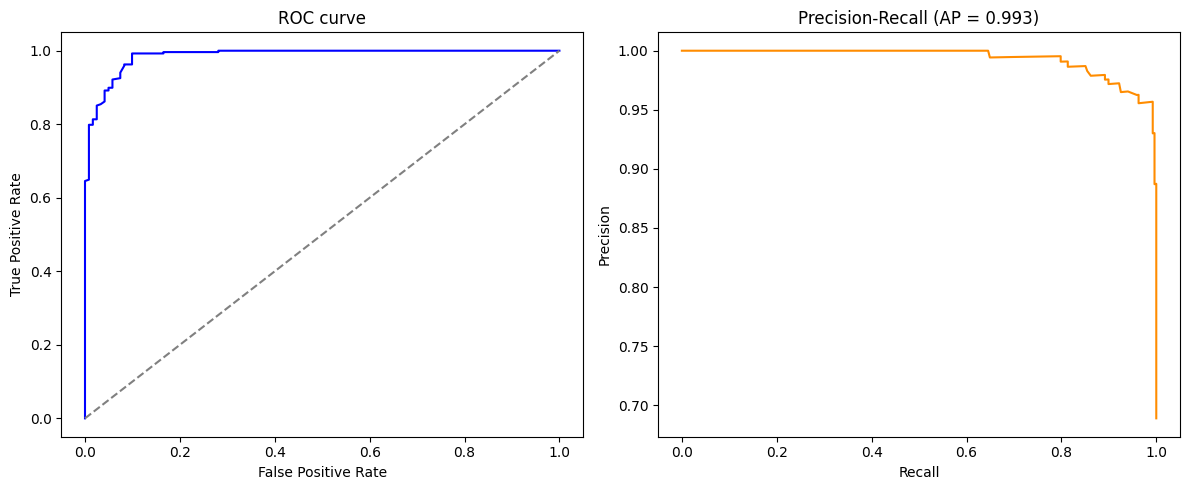

In [35]:
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

fpr, tpr, thr     = roc_curve(y_test, y_prob)
prec, rec, thr_pr = precision_recall_curve(y_test, y_prob)
ap                = average_precision_score(y_test, y_prob)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='blue')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot(1,2,2)
plt.plot(rec, prec, color='darkorange')
plt.title(f'Precision-Recall (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.show()

In [36]:
import joblib

joblib.dump(pipe, "rf_model_pipeline.pkl")
print("✅ Modelo guardado como rf_model_pipeline.pkl")

✅ Modelo guardado como rf_model_pipeline.pkl


Accuracy: 0.9485861182519281
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       121
           1       0.96      0.97      0.96       268

    accuracy                           0.95       389
   macro avg       0.94      0.94      0.94       389
weighted avg       0.95      0.95      0.95       389



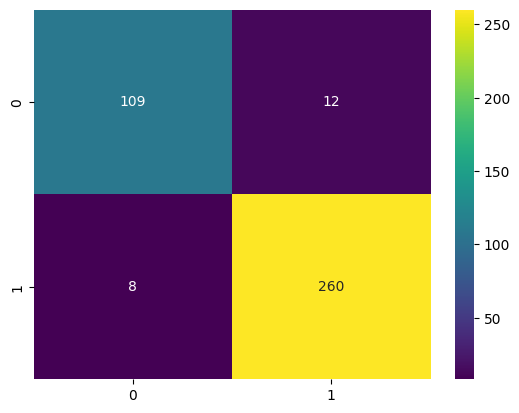

In [37]:
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='viridis')
plt.show()

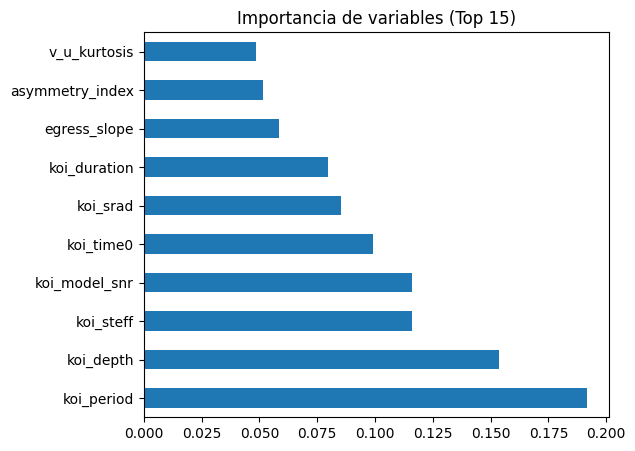

In [38]:
rf_model = pipe.named_steps['rf']
importancias = pd.Series(rf_model.feature_importances_, index=X.columns)
importancias.nlargest(15).plot(kind='barh', figsize=(6,5))
plt.title("Importancia de variables (Top 15)")
plt.show()

In [ ]:
umbral = 0.50

proba_test = pipe.predict_proba(X_test)[:, 1]
pred_test01 = (proba_test >= umbral).astype(int)

# mapear a texto
pred_test_label = pd.Series(pred_test01).map({1: "exoplaneta", 0: "no exoplaneta"})

res_test = pd.DataFrame({
    "index": X_test.index,
    "proba_exoplaneta": proba_test,
    "pred_binaria": pred_test01,
    "pred_etiqueta": pred_test_label,
    "y_real": y_test.values
})

display(res_test.head(15))

,index,proba_exoplaneta,pred_binaria,pred_etiqueta,y_real
0,335,1.000000,1,exoplaneta,1
1,484,1.000000,1,exoplaneta,1
2,470,0.920000,1,exoplaneta,1
3,1032,0.923333,1,exoplaneta,1
4,983,0.143333,0,no exoplaneta,0
5,1624,0.376667,0,no exoplaneta,0
6,1878,0.756667,1,exoplaneta,1
7,1090,0.133333,0,no exoplaneta,0
8,1304,0.216667,0,no exoplaneta,0
9,288,1.000000,1,exoplaneta,1
